In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
from numpy import newaxis, fill_diagonal, sum, sqrt
NA = newaxis

# Experimental values for Argon atoms
EPSILON=0.997; # kJ/mol
SIGMA=  3.401; # Ångstrom


def distance(points):
    # points: (N,3)-array of (x,y,z) coordinates for N points
    # distance(points): returns (N,N)-array of inter-point distances:
    displacement = points[:, NA] - points[NA, :]
    return sqrt(sum(displacement*displacement, axis=-1))


def LJ(sigma=SIGMA, epsilon=EPSILON):
    def V(points):
        # points: (N,3)-array of (x,y,z) coordinates for N points
        dist = distance(points)

        # Fill diagonal with 1, so we don't divide by zero
        fill_diagonal(dist, 1)

        # dimensionless reciprocal distance
        f = sigma/dist

        # calculate the interatomic potentials
        pot = 4*epsilon*(f**12 - f**6)

        # Undo any diagonal terms (the particles don't interact with themselves)
        fill_diagonal(pot, 0)

        # We could return the sum of just the upper triangular part, corresponding
        # to equation 2 in the assignment text. But since the matrix is symmetric,
        # we can just sum over all elements and divide by 2
        return sum(pot)/2
    return V


def LJgradient(sigma=SIGMA, epsilon=EPSILON):
    def gradV(X):
        d = X[:, NA] - X[NA, :]
        r = sqrt(sum(d*d, axis=-1))

        fill_diagonal(r, 1)

        T = 6*(sigma**6)*(r**-7)-12*(sigma**12)*(r**-13)
        # (N,N)−matrix of r−derivatives
        # Using the chain rule , we turn the (N,N)−matrix of r−derivatives into
        # the (N,3)−array of derivatives to Cartesian coordinate: the gradient.
        # (Automatically sets diagonal to (0,0,0) = X[ i]−X[ i ])
        u = d/r[:, :, NA]
        # u is (N,N,3)−array of unit vectors in direction of X[ i ]−X[ j ]
        return 4*epsilon*sum(T[:, :, NA]*u, axis=1)
    return gradV


# wrapper functions to generate "flattened" versions of the potential and gradient.
def flatten_function(f):
    return lambda x: f(x.reshape(-1, 3))


def flatten_gradient(f):
    return lambda x: f(x.reshape(-1, 3)).reshape(-1)

# potential and gradient with values for Argon
V = LJ()
gradV = LJgradient()

# Flattened potential and gradient.
flat_V     = flatten_function(V)
flat_gradV = flatten_gradient(gradV)


In [3]:
# This cell contains my QR solver from project 1

def householder_fast(A):
    """This function takes a m x n matrix A and uses the Householder method to compute the upper triangular n x n matrix R and stores the reflection vectors v"""
    
    R = np.copy(A)  #initialize R
    V = []  #create empty list to store reflection vectors
    
    for i in range(np.min(np.shape(A))):  #loop over columns
        e = np.zeros(np.max(np.shape(A)))  #create e_i-vector
        e[i] = 1
        
        a_i = np.copy(R[:,i])  #make a copy of the i'th column in R
        a_i[:i] = 0  #set all indices above i to zero
        
        v_i = a_i - np.copysign(np.linalg.norm(a_i) * e, -a_i[0])  #compute vector v for the i'th column
        
        V.append(v_i)  #append vector v to list V
        
        if np.dot(v_i,v_i) == 0:  #skip current column if it is already zero
            continue
        
        for j in range(i, np.min(np.shape(A))):  #apply Householder transformation to remaining columns in R
            R[:,j] -= ((2 * np.dot(v_i, R[:,j])) / np.dot(v_i, v_i)) * v_i
                      
    R = R[:np.min(np.shape(A)),:]  #remove bottom rows that are zero
    
    return V, R


def back_substitute(U,y):
    """This function takes a square upper triangular matrix U and a vector y and returns the solution vector x to the system Ux=y"""
    
    y = np.copy(y)  #initialize y
    x = np.zeros(len(U))  #initialize solution x
    singular_matrix = False  #initialize test for singular matrix

    for j in range(len(U)-1,-1,-1):  #loop backwards over columns in U
        if U[j,j] == 0:
            print("singular matrix")
            #singular_matrix = True
            #break  #stop if the matrix is singular
        
        x[j] = y[j] / U[j,j]  #calculate the j-component of the solution
        
        for i in range(j):  #loop over the j first rows in U
            y[i] = y[i] - U[i,j] * x[j]  #update y
    
    return x, singular_matrix


def qr_solve(A, b):
    """This function takes a m x n matrix A and an m vector b and returns the least squares solution n vector x_tilde to A*x_tilde=b and the residual r"""
    
    b = np.copy(b)  #initialize b
    V, R = householder_fast(A)  #compute reflection vectors and matrix R
    
    for i in range(len(V)):  #loop over reflection vectors
        
        if np.dot(V[i],V[i]) == 0:  #skip current column if it is already zero
            continue
        
        b -= ((2 * np.dot(V[i], b)) / np.dot(V[i], V[i])) * V[i]  #update right hand side by applying Householder transformation to b
    
    x_tilde, singular_matrix = back_substitute(R, b[:np.min(np.shape(A))])  #compute x_tilde using back substitution on R and the first n entries in b
    
    r = np.linalg.norm(b[np.min(np.shape(A)):np.max(np.shape(A))])  #compute residual as the norm of the remaining entries in b

    return x_tilde, r, singular_matrix

In [4]:
# This cell contains the 3D plotting functions provided in the problem set

# Experimental value for sigma (in Ånsgtrom)
SIGMA = 3.401
# Length of minimal potential strength
minlen = 2**(1/6) * SIGMA


# Helper functions for pretty 3d plots easily
def create_3d_plot():
    # We need to pass this dictionary to all subplots we create, so the axes becomes 3D
    plot_dict = dict(projection='3d')
    fig, ax = plt.subplots(subplot_kw=plot_dict)
    return fig, ax


def make_axis_equal(ax):
    # It is incredibly annoying to get an equal aspect ratio in 3d using matplotlib
    # What we need to do is set all the coordinate axis limits equal. This function does just that.
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    z1, z2 = ax.get_zlim()
    
    m1 = min(x1, y1, z1)
    m2 = max(x2, y2, z2)
    ax.set_xlim(m1, m2)
    ax.set_ylim(m1, m2)
    ax.set_zlim(m1, m2)
    
    # Also, we need to use orthographic projection instead of perspective projection
    ax.set_proj_type("ortho")
    return ax


def transparent_axis_background(ax):
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # Disable the axes
    ax.axis("off")
    return ax


def plot_min_distances(ax, points, cutoff=1.01*minlen):
    # points: (N,3)-array of (x,y,z) coordinates for N points
    # distance(points): returns (N,N)-array of inter-point distances:
    displacement = points[:, np.newaxis] - points[np.newaxis, :]
    r = np.sqrt(np.sum(displacement*displacement, axis=-1))
    
    # Grab only those that are in upper triangular part
    r = np.triu(r)
    
    # Grab lengths that are above 0, but below the cutoff
    mask = (r <= cutoff) * (r > 0)
    
    # Grab the indices of elements that satisfy the mask above
    ii, jj = np.where(mask)
    
    # For each pair of indices (corresponding to a distance close to optimal)
    # we plot a line between the corresponding points
    for i, j in zip(ii, jj):
        p = points[[i, j]]
        ax.plot(*p.T, color='k', ls="-")
    return ax


def create_base_plot(points):
    # Create the figure and 3D axis
    fig, ax = create_3d_plot()
    
    # translate points so centre of mass is at origin
    m = np.mean(points, axis=0)
    points = np.array(points) - m[np.newaxis, :]
    
    # Plot points and lines between points that are near to optimal
    ax.scatter(*points.T)
    ax = plot_min_distances(ax, points)
    return ax, points


def make_plot_pretty(ax):
    # Make the plot pretty
    ax = transparent_axis_background(ax)
    ax = make_axis_equal(ax)
    return ax

# 2.1 Solving Nonlinear Equations in 1D

## Problem a

Text(0.5, 1.0, 'Potential strength between two particles')

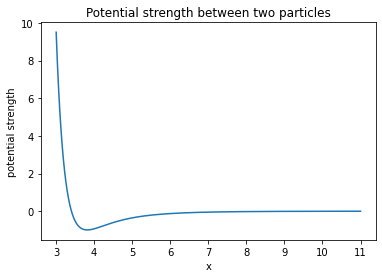

In [5]:
pot2 = lambda x: V(np.array([[x, 0, 0], [0, 0, 0]]))  #this function calculates the potential between two particles
x = np.linspace(3, 11, 1000)  #position values

pot2_array = np.zeros(len(x))  #initialize array for potential values
for i in range(len(x)):  #calculate potential for each position x
    pot2_array[i] = pot2(x[i])

#plot potential as a function of position (two particles)
plt.plot(x, pot2_array)
plt.xlabel("x")
plt.ylabel("potential strength")
plt.title("Potential strength between two particles")

Text(0.5, 1.0, 'Potential strength between four particles')

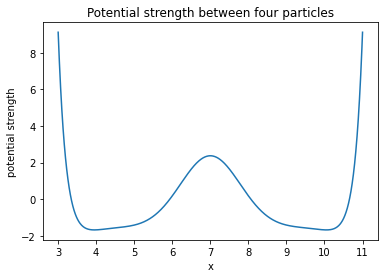

In [6]:
pot4 = lambda x: V(np.array([[x, 0, 0], [0, 0, 0], [14, 0, 0], [7, 3.2, 0]]))  #this function calculates the potential between four particles
x = np.linspace(3, 11, 1000)  #x values

pot4_array = np.zeros(len(x))  #initialize array for potential values
for i in range(len(x)):  #calculate potential for each value of x
    pot4_array[i] = pot4(x[i])

#plot potential as a function of x (four particles)
plt.plot(x, pot4_array)
plt.xlabel("x")
plt.ylabel("potential strength")
plt.title("Potential strength between four particles")

## Problem b

In [7]:
def bisection_root(f, a, b, tolerance=1e-13):
    """This function takes a function f and a bracket around a zero [a,b] and finds the corresponding root of f"""
    
    n_calls = 0  #initialize number of function calls
    m = a + (b - a) / 2  #initialize midtpoint
    fm = 1  #initialize function value at midtpoint
    
    while np.abs(fm) > tolerance:  #loop until f(m) is close enough to zero
        #perform bisection root finding
        m = a + (b - a) / 2
        fm = f(m)
        fa = f(a)
        
        if np.sign(fa) == np.sign(fm):
            a = m
        else:
            b = m
            
        n_calls += 2  #count number of function calls
            
    return m, n_calls

In [8]:
x, n_calls = bisection_root(pot2, a=2, b=6)  #perform bisection root finding to find the distance x where the LJ-potential between two particles is zero

print("Sigma:", SIGMA)  #I print sigma to check if I get the same value for the root
print("Root:", x)
print("Number of function calls:", n_calls)

Sigma: 3.401
Root: 3.4010000000000105
Number of function calls: 92


## Problem c

In [9]:
def LJderiv(sigma=SIGMA, epsilon=EPSILON):
    """This function calculates the derivative of the pair-potential"""
    def dV(x, sigma=SIGMA, epsilon=EPSILON):
        d_V = 4*epsilon*(6*sigma**6/x**7 - 12*sigma**12/x**13)  #calculate derivative
        return d_V
    return dV

dV = LJderiv()

def newton_root(f, df, x0, tolerance=1e-12, max_iterations=1000):
    """This function takes a function f, its derivative df and an initial guess x0 and uses the Newton-Rhapson method to find a root of f"""
    
    x = np.copy(x0)  #initialize approximate root
    n_calls = 0  #initialize number of function calls
    
    for i in range(max_iterations):  #perform Newton-Rhapson root finding
        fx = f(x)
        dfx = df(x)
        
        x = x - fx / dfx
        
        n_calls += 2
        
        if np.abs(fx) < tolerance:  #chech if f(x) is close enough to zero
            break
            
    return x, n_calls

In [10]:
x, n_calls = newton_root(pot2, dV, x0=2)  #perform Newton-Rhapson root finding to find the root of the two particle system

#print result
print("Sigma:", SIGMA)
print("Root:", x)
print("Number of function calls:", n_calls)

Sigma: 3.401
Root: 3.4009999999999994
Number of function calls: 26


## Problem d

In [11]:
def combi_root(f, df, a, b, x0, tolerance=1e-13):
    """This function takes a function f, its derivative df, an interval [a,b] bracketing a zero and an initial guess x and uses a combination of the Newton-Rhapson and bisection methods to find a root of f"""
    
    x = x0  #initialize approximate root
    n_calls = 0  #initialize number of function calls
    fx = 1  #initialize value of f(x)
    
    while np.abs(fx) > tolerance:  #loop until
        #perform Newton-Rhapson root finding
        fx = f(x)
        dfx = df(x)
        
        x = x - fx / dfx
        n_calls += 2
        
        if x < np.min((a, b)) or x > np.max((a, b)):  #if the approximate root falls outside the bracket, then perform bisection root finding
            x = a + (b - a) / 2
            if np.sign(f(a)) == np.sign(f(x)):
                a = x
            else:
                b = x
            
            n_calls += 2
    
    return x, n_calls

In [12]:
x, n_calls = combi_root(pot2, dV, a=2, b=6, x0=2)  #perform the combination routine on the two particle system

#print the result
print("Sigma:", SIGMA)
print("Root:", x)
print("Number of function calls:", n_calls)

Sigma: 3.401
Root: 3.4009999999999994
Number of function calls: 26


# 2.2 Solving N-dimensional Nonlinear Equations

## Problem e

In [13]:
grad_pot2 = lambda x: gradV(np.array([[x, 0, 0], [0, 0, 0]]))  #this function calculates the gradient of the potential for the 2-particle system

# I look at the gradient of the 2-particle system for x=3, x=7 and x=10
print("Gradient of 2-particle system at x=3:")
print(grad_pot2(3), "\n")

print("Gradient of 2-particle system at x=7:")
print(grad_pot2(7), "\n")

print("Gradient of 2-particle system at x=10:")
print(grad_pot2(10))

Gradient of 2-particle system at x=3:
[[-54.9536532   0.          0.       ]
 [ 54.9536532   0.          0.       ]] 

Gradient of 2-particle system at x=7:
[[ 0.0437806  0.         0.       ]
 [-0.0437806  0.         0.       ]] 

Gradient of 2-particle system at x=10:
[[ 0.00369148  0.          0.        ]
 [-0.00369148  0.          0.        ]]


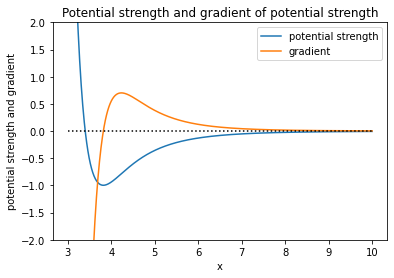

In [14]:
x = np.linspace(3, 10, 1000)  #array of position values

pot2_array = np.zeros(len(x))  #initialize array of potential values
grad_pot2_array = np.zeros(len(x))  #initialize array of derivative values

for i in range(len(x)):  #calculate potential and (0,0)-component of gradient for each x
    pot2_array[i] = pot2(x[i])
    grad_pot2_array[i] = grad_pot2(x[i])[0,0]

#plot results
plt.plot(x, pot2_array, label="potential strength")
plt.plot(x, grad_pot2_array, label="gradient")
plt.plot((3, 10), (0, 0), "k:")
plt.xlabel("x")
plt.ylabel("potential strength and gradient")
plt.ylim(-2, 2)
plt.title("Potential strength and gradient of potential strength")
plt.legend()

In [15]:
grad_pot4 = lambda x: gradV(np.array([[x, 0, 0], [0, 0, 0], [14, 0, 0], [7, 3.2, 0]]))  #this function calculates the gradient of the potential for the 4-particle system
x = np.linspace(3, 11, 1000)  #array of x-values (the same array I used when creating pot4_array)

pot_min = np.min(pot4_array)  #find the value of the potential at one of the minima
index = np.where(pot4_array == pot_min)[0][0]  #find the index of this minimum
x_min = x[index]  #find the x-value at the minimum using the index

print("One of the minima of the 4-particle system is at x =", x_min)

One of the minima of the 4-particle system is at x = 3.952952952952953


In [16]:
#I print the gradient at the minimum
print("The gradient at the minimun is:")
print(grad_pot4(x_min), "\n")

print("Summing over each particle, the gradient at the minimum is:")
print(np.round(np.sum(grad_pot4(x_min), axis=0), 12))

The gradient at the minimun is:
[[ 0.00636246 -0.47632766  0.        ]
 [-0.48457968 -0.00947811  0.        ]
 [ 0.02465697 -0.00947811  0.        ]
 [ 0.45356025  0.49528388  0.        ]] 

Summing over each particle, the gradient at the minimum is:
[-0. -0.  0.]


## Problem f

In [17]:
def linesearch(F, X0, d, alpha_max, tolerance=10e-13, max_iterations=1000):
    """This function takes a function F, a position X0, a direction d and a maximum alpha value and performs linesearch to find a zero of F(X0) along the direction d"""
    
    def dotproduct(alpha):  #restrict F to line and perform dot product with d
        dot_product = np.sum(d * F(X0 + alpha * d))
        return  dot_product
    
    alpha, n_calls = bisection_root(dotproduct, a=0, b=alpha_max, tolerance=tolerance)  #search for root using bisection
    
    return alpha, n_calls

In [18]:
X0 = np.array([[4,0,0], [0,0,0], [14,0,0], [7, 3.2, 0]])  #define X0
d = - gradV(X0)  #the linesearch is going to be performed along the direction of the negative gradient

alpha, n_calls = linesearch(gradV, X0, d, alpha_max=1)  #perform linesearch to find zero of gradient along the direction of the negative gradient

#print result
print("alpha =", alpha)
print("Number of function calls:", n_calls)

alpha = 0.451707051842277
Number of function calls: 80


## Problem g

In [19]:
ArStart = np.load('ArStart.npz')  #load starting positions

In [20]:
def golden_section_min(f, a, b, tolerance=1e-6):
    """This function takes a function f and an interval [a,b] and performs golden section search to find a minimum in the interval"""
    
    #initialize parameters
    tau = (np.sqrt(5) - 1) / 2
    x1 = a + (1 - tau) * (b - a)
    f1 = f(x1)
    x2 = a + tau * (b - a)
    f2 = f(x2)
    
    n_calls = 2  #initialize number of function calls (the function is called twice when initializing)
    
    while (b - a) > tolerance:
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + tau * (b - a)
            f2 = f(x2)
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (1 - tau) * (b - a)
            f1 = f(x1)
    
        n_calls += 1  #count number of function calls
        
    return x1, n_calls

In [21]:
def find_alpha_golden_section(F, X0, d, alpha_min, alpha_max):
    """This function takes a function F, a position X0, a direction d and minimum and maximum values of alpha and finds the linesearch paramenter alpha using golden section search"""
    
    def F_on_line(alpha):  #restrict F to line
        return F(X0 + d * alpha)
    
    alpha, n_calls = golden_section_min(F_on_line, alpha_min, alpha_max)  #perform golden section search on line restricted function
    
    return alpha, n_calls

In [22]:
X0 = np.array([[4,0,0], [0,0,0], [14,0,0], [7, 3.2, 0]])  #define position
d = - gradV(X0)  #the direction is the negative gradient

alpha, n_calls = find_alpha_golden_section(flat_V, X0, d, alpha, alpha_max=1)  #find alpha using golden section search

#print result
print("alpha =", alpha)
print("Number of function calls:", n_calls)

alpha = 0.45170734654452777
Number of function calls: 30


In [23]:
#I find the optimal distance between two particles using golden section search
#I have chosen the interval (3,5) because I can see on the plot above that the minimum of the potential lies in this interval

r0, n_calls = golden_section_min(pot2, 3, 5)  #perform golden section search on the potential of the 2-particle system

#print result
print("r0 =", r0)
print("Number of function calls:", n_calls)

r0 = 3.8174932404164
Number of function calls: 33


## Problem h

In [24]:
def BFGS(f, gradf, X_initial, tolerance=1e-6, max_iterations = 10000):
    """This function takes a function f, its gradient gradf and a starting position X_initial and uses the BFGS method to find a minimum of the function f"""
    
    converged = False  #initialize whether convergence has been achieved
    x = np.copy(X_initial)  #initialize approximate minimum position
    B = np.identity(len(x))  #initialize approximate Hessian
    n_calls = 1  #initialize number of function calls (set to 1 because I call gradf when initializing)
    gradfx = gradf(x)  #initialize gradient
      
    for i in range(max_iterations):  #perform BFGS until convergence has been achieved or the maximum number of iterations has been reached
        
        gradient_old = gradfx  #gradient of the old x-value
        
        s = np.linalg.solve(B, -gradient_old)
        x += s
        gradfx = gradf(x)  #update gradient
        y = gradfx - gradient_old
        B += np.outer(y, y) / np.dot(y, s) - np.matmul(B, np.matmul(np.outer(s, s), B)) / np.dot(s, np.matmul(B, s))
        
        n_calls += 1  #count number of function calls
        
        if np.linalg.norm(gradfx) < tolerance:  #break and set convergence true iff convergence has been achieved
            converged = True
            n_steps = i + 1  #count number of BFGS steps (plus 1 because for the first step i=0)
            break
    
    return x, converged, n_calls, n_steps

In [25]:
x, converged, n_calls, n_steps = BFGS(flat_V, flat_gradV, ArStart["Xstart2"])  #find minimum of 2-particle system using BFGS

x_reshaped = x.reshape(-1,3)  #reshape optimal x
D = distance(x_reshaped)  #calculate distance matrix

print("This distance matrix at the found minimum for the 2-particle system:")
print(D, "\n")

r0 = D[0,1]  #optimal distance between the two particles
print("r0 =", r0)
print("Number of function calls:", n_calls)
print("Number of BFGS steps:", n_steps)
print("Convergence was achieved:", converged)

This distance matrix at the found minimum for the 2-particle system:
[[0.         3.81749343]
 [3.81749343 0.        ]] 

r0 = 3.817493425601058
Number of function calls: 7
Number of BFGS steps: 6
Convergence was achieved: True


## Problem i

In [26]:
x_list = []  #initialize list of found minimal energy configurations
converged_list = []  #initialize list of whether convergence was achieved
n_calls_list = []  #initialize list of number of function calls
n_steps_list = []  #initialize list of number of BFGS steps
distances_within_1_percent = []  #initialize list of number of distances within 1 % of r0

for item in ArStart.files[:-1]:  #perform BFGS for all the particles
    x, converged, n_calls, n_steps = BFGS(flat_V, flat_gradV, ArStart[item])
    
    if not converged:  #stop if I reach N that I can't get to converge
        print("not converged")
        break
    
    x_reshaped = x.reshape(-1,3)  #reshape x
    x_list.append(x_reshaped)
    
    converged_list.append(converged)
    
    D = distance(x_reshaped)  #calculate distance matrix
    distances_within_1_percent.append(np.sum(np.abs(D-r0)/r0 <= 0.02)//2)
    
    n_calls_list.append(n_calls)
    n_steps_list.append(n_steps)

In [27]:
#print results
for i in range(len(x_list)):
    print(ArStart.files[:-1][i])
    print("Convergence was reached:", converged_list[i])
    print("Number of function calls:", n_calls_list[i])
    print("Number of BFGS steps:", n_steps_list[i])
    print("Number of distances within 1 % of r0:", distances_within_1_percent[i], "\n")

Xstart2
Convergence was reached: True
Number of function calls: 7
Number of BFGS steps: 6
Number of distances within 1 % of r0: 1 

Xstart3
Convergence was reached: True
Number of function calls: 17
Number of BFGS steps: 16
Number of distances within 1 % of r0: 0 

Xstart4
Convergence was reached: True
Number of function calls: 20
Number of BFGS steps: 19
Number of distances within 1 % of r0: 0 

Xstart5
Convergence was reached: True
Number of function calls: 50
Number of BFGS steps: 49
Number of distances within 1 % of r0: 0 

Xstart6
Convergence was reached: True
Number of function calls: 30
Number of BFGS steps: 29
Number of distances within 1 % of r0: 0 

Xstart7
Convergence was reached: True
Number of function calls: 360
Number of BFGS steps: 359
Number of distances within 1 % of r0: 0 

Xstart8
Convergence was reached: True
Number of function calls: 26
Number of BFGS steps: 25
Number of distances within 1 % of r0: 0 

Xstart9
Convergence was reached: True
Number of function calls

Text(0.5, 0.92, 'N = 20')

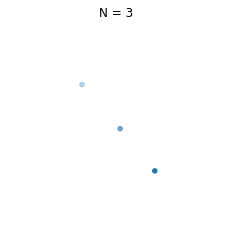

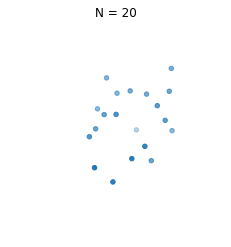

In [28]:
#plot the found minimal energy configuration for N=3 and N=20
ax3, _ = create_base_plot(x_list[1])
make_plot_pretty(ax3)
ax3.set_title("N = 3")

ax20, _ = create_base_plot(x_list[-1])
make_plot_pretty(ax20)
ax20.set_title("N = 20")

## Problem j

In [29]:
def BFGS_linesearch(f, gradf, X_initial, tolerance=1e-6, max_iterations = 10000):
    """This is the same BFGS function as above but with a linesearch along direction s added"""
    
    #initialize parameters
    converged = False
    x = np.copy(X_initial)
    B = np.identity(len(x))
    gradfx = gradf(x)
    n_calls = 1
      
    for i in range(max_iterations):
        
        gradient_old = gradfx
        
        s = np.linalg.solve(B, -gradient_old)
        
        alpha, n_calls_linesearch = find_alpha_golden_section(f, x, s, -1, 1)  #linesearch step where the linesearch parameter alpha along direction s is found using golden section search
        
        s *= alpha  #s is dampened by alpha
        x += s
        gradfx = gradf(x)
        y = gradfx - gradient_old
        B += np.outer(y, y) / np.dot(y, s) - np.matmul(B, np.matmul(np.outer(s, s), B)) / np.matmul(np.matmul(B, s), s)
        
        n_calls += (1 + n_calls_linesearch)
        
        if np.linalg.norm(gradfx) < tolerance:
            converged = True
            n_steps = i + 1
            break
    
    return x, converged, n_calls, n_steps

In [30]:
#initialize lists
x_list1 = []
converged_list1 = []
n_calls_list1 = []
n_steps_list1 = []
distances_within_1_percent1 = []

for item in ArStart.files[:-1]:  #perform BFGS for all the particles
    x, converged, n_calls, n_steps = BFGS_linesearch(flat_V, flat_gradV, ArStart[item])
    
    if not converged:  #stop if I reach N that I can't get to converge
        print("not converged")
        break
    
    x_reshaped = x.reshape(-1,3)  #reshape x
    x_list1.append(x_reshaped)
    
    converged_list1.append(converged)
    
    D = distance(x_reshaped)  #calculate distance matrix
    distances_within_1_percent1.append(np.sum(np.abs(D-r0)/r0 <= 0.02)//2)
    
    n_calls_list1.append(n_calls)
    n_steps_list1.append(n_steps)

In [31]:
#print the results
for i in range(len(x_list)):
    print(ArStart.files[:-1][i])
    print("The BFGS with linesearch algorithm converged:", converged_list1[i])
    print("Number of function calls:", n_calls_list1[i])
    print("Number of BFGS steps:", n_steps_list1[i])
    print("Number of distances within 1 % of r0:", distances_within_1_percent1[i], "\n")

Xstart2
The BFGS with linesearch algorithm converged: True
Number of function calls: 35
Number of BFGS steps: 1
Number of distances within 1 % of r0: 1 

Xstart3
The BFGS with linesearch algorithm converged: True
Number of function calls: 409
Number of BFGS steps: 12
Number of distances within 1 % of r0: 3 

Xstart4
The BFGS with linesearch algorithm converged: True
Number of function calls: 681
Number of BFGS steps: 20
Number of distances within 1 % of r0: 6 

Xstart5
The BFGS with linesearch algorithm converged: True
Number of function calls: 2551
Number of BFGS steps: 75
Number of distances within 1 % of r0: 9 

Xstart6
The BFGS with linesearch algorithm converged: True
Number of function calls: 1973
Number of BFGS steps: 58
Number of distances within 1 % of r0: 12 

Xstart7
The BFGS with linesearch algorithm converged: True
Number of function calls: 9623
Number of BFGS steps: 283
Number of distances within 1 % of r0: 15 

Xstart8
The BFGS with linesearch algorithm converged: True
N

Text(0.5, 0.92, 'N = 20')

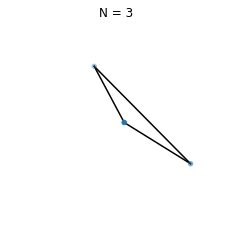

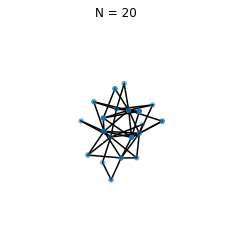

In [32]:
#plot the found minimal energy configuration for N=3 and N=20
ax3, _ = create_base_plot(x_list1[1])
make_plot_pretty(ax3)
ax3.set_title("N = 3")

ax20, _ = create_base_plot(x_list1[-1])
make_plot_pretty(ax20)
ax20.set_title("N = 20")